In [46]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob, os
from keras.models import Model, load_model
from sklearn.utils import shuffle
from imgaug import augmenters as iaa
from tensorflow.keras import layers, models
import tensorflow as tf
import random

In [47]:
npz_file = np.load('./x_real.npz')

# Extract the array from the loaded file
re= npz_file['data']

import cv2

resized_images = []
for img in re:
    resized_img = cv2.resize(img, (90, 90))
    resized_images.append(resized_img)

resized_images = np.array(resized_images)
x_real_resized = resized_images[..., np.newaxis]



In [48]:
npz_file = np.load('./x_medium.npz')

# Extract the array from the loaded file
med= npz_file['data']
import cv2

resized_images = []
for img in med:
    resized_img = cv2.resize(img, (90, 90))
    resized_images.append(resized_img)

resized_images = np.array(resized_images)
x_med_resized = resized_images[..., np.newaxis]

# LOAD DATASET

In [49]:
x_real = x_real_resized
y_real = np.load('./y_real.npy')
x_medium = x_med_resized
y_medium = np.load('./y_medium.npy')
print(x_real.shape, y_real.shape)


(6000, 90, 90, 1) (6000, 4)


#  Test data


In [50]:
x_data = x_medium
label_data = y_medium 
print(x_data.shape, label_data.shape)


(17067, 90, 90, 1) (17067, 4)


# Make Label Dictionary Lookup Table

In [51]:
label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i

# Testing


In [52]:
import os

model_dir = '/home/yusuf/Desktop/yusuf/ai vanits/my_model'

# Check if the directory exists
if os.path.exists(model_dir):
    print(f"Directory '{model_dir}' exists.")
else:
    print(f"Directory '{model_dir}' does not exist.")

# List the contents of the directory
for root, dirs, files in os.walk(model_dir):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")


Directory '/home/yusuf/Desktop/yusuf/ai vanits/my_model' exists.
Root: /home/yusuf/Desktop/yusuf/ai vanits/my_model
Directories: ['assets', 'variables']
Files: ['fingerprint.pb', 'keras_metadata.pb', 'saved_model.pb']
Root: /home/yusuf/Desktop/yusuf/ai vanits/my_model/assets
Directories: []
Files: []
Root: /home/yusuf/Desktop/yusuf/ai vanits/my_model/variables
Directories: []
Files: ['variables.index', 'variables.data-00000-of-00001']


In [53]:
import tensorflow as tf
import os

# Get the absolute path to avoid any path-related issues
model_dir = os.path.abspath('./my_model')
# Set experimental I/O device options
options = tf.saved_model.LoadOptions(
    experimental_io_device='/job:localhost'
)
model = tf.saved_model.load(model_dir, options=options)


In [54]:
from keras.models import load_model
import os

# Get the absolute path to avoid any path-related issues
model_dir = os.path.abspath('./my_model')

# Load the model
model = load_model(model_dir)


1/1 [==============================] - 0s 29ms/step


/tmp/ipykernel_194061/896694816.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('O: %.02f, %s' % (pred_rx, ry))
/tmp/ipykernel_194061/896694816.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('X: %.02f, %s' % (pred_ux, uy))


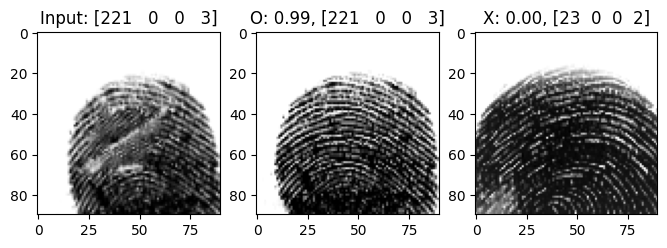

In [56]:

# new user fingerprint input
random_idx = random.randint(0, len(x_data))

random_img = x_data[random_idx]
random_label = label_data[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# unmatched image
unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
uy = y_real[unmatch_idx]

pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(ux.squeeze(), cmap='gray')
